In [1]:
from source_codes.ranking_models_hptunable import ranking_alone_model_hp

def build_model(hp):
    hp_model = ranking_alone_model_hp(
        # feature extraction hyperparameters
        backbone='vgg19',
        backbone_weights='imagenet',

        # subnetwork hyperparameters
        r_num_dense=hp.Int('r_num_dense', max_value=4, min_value=2, step=1, default=2),
        r_dense_dropout=True,
        r_dense_units=hp.Int('r_dense_units', max_value=4096, min_value=512, step=512, default=1024),
        r_sub_dense_mode=hp.Choice('r_sub_dense_mode', ['parallel', 'decreasing'], default='decreasing'),
        r_dense_dropout_rate=hp.Float(name='r_dense_dropout_rate', max_value=0.5, min_value=0.1, step=0.1),
        r_l1=hp.Float('r_l1', max_value=1e-4, min_value=1e-6, step=10, sampling='log', default=1e-5),
        r_l2=hp.Float('r_l2', max_value=1e-4, min_value=1e-6, step=10, sampling='log', default=1e-5),

        # compilation hyperparameters
        optimizer=hp.Choice('optimizer', ['sgd', 'adam'], default='sgd'),
        decay=hp.Float('decay', max_value=1e-6, min_value=1e-8, step=10, sampling='log', default=1e-7),
        learning_rate=hp.Float('learning_rate', max_value=1e-6, min_value=1e-8, step=10, sampling='log', default=1e-7),
    )
    return hp_model


In [2]:

# prepare data
import numpy as np
import os

question_index = str(3)

# training data
x_left_training = np.load(
    os.path.join('data/ForModelTraining/train_data/draw_exclude/train_left_duel_' + question_index + '.npy'), allow_pickle=True)
x_right_training = np.load(
    os.path.join('data/ForModelTraining/train_data/draw_exclude/train_right_duel_' + question_index + '.npy'),
    allow_pickle=True)
y_training = np.load(os.path.join('data/ForModelTraining/train_data/draw_exclude/train_label_duel_' + question_index + '.npy'),
                     allow_pickle=True)

# validation data
x_left_val = np.load(
    os.path.join('data/ForModelTraining/validation_data/draw_exclude/val_left_duel_' + question_index + '.npy'),
    allow_pickle=True)
x_right_val = np.load(
    os.path.join('data/ForModelTraining/validation_data/draw_exclude/val_right_duel_' + question_index + '.npy'),
    allow_pickle=True)
y_val = np.load(os.path.join('data/ForModelTraining/validation_data/draw_exclude/val_label_duel_' + question_index + '.npy'),
                allow_pickle=True)

# test data
x_left_test = np.load(os.path.join('data/ForModelTraining/test_data/draw_exclude/test_left_duel_' + question_index + '.npy'),
                      allow_pickle=True)
x_right_test = np.load(os.path.join('data/ForModelTraining/test_data/draw_exclude/test_right_duel_' + question_index + '.npy'),
                       allow_pickle=True)
y_test = np.load(os.path.join('data/ForModelTraining/test_data/draw_exclude/test_label_duel_' + question_index + '.npy'),
                 allow_pickle=True)

In [3]:

# configure hp model
import keras_tuner as kt

build_model(kt.HyperParameters())

val_rank_accuracy_obj = kt.Objective("val_ranking_accuracy", direction="max")

hp_date = '060223'

tuner = kt.BayesianOptimization(
    build_model,
    objective=[val_rank_accuracy_obj],
    max_trials=24,
    executions_per_trial=4,
    overwrite=False,
    directory='model_results/Q3/hp_tuning',
    project_name="hptuning_ranking_" + hp_date,
)

In [4]:

# search hp model
from keras import callbacks

early_stopping = callbacks.EarlyStopping(
    monitor="val_loss",
    patience=15,
    mode='min',
    restore_best_weights=True
)

tuner.search(
    x=[x_left_training, x_right_training],
    y=y_training,
    epochs=80,
    batch_size=32,
    validation_data=([x_left_val, x_right_val], y_val),
    callbacks=[early_stopping]
)

# Get the top 10 hyperparameters results
tuner.results_summary()


Trial 24 Complete [00h 44m 29s]
multi_objective: -0.6749783903360367

Best multi_objective So Far: -0.6984622180461884
Total elapsed time: 16h 55m 42s
INFO:tensorflow:Oracle triggered exit
Results summary
Results in model_results/Q3/hp_tuning\hptuning_ranking_060223
Showing 10 best trials
MultiObjective(name="multi_objective", direction="min"): [Objective(name="val_ranking_accuracy", direction="max")]

Trial 18 summary
Hyperparameters:
r_num_dense: 3
r_dense_units: 3584
r_sub_dense_mode: parallel
r_dense_dropout_rate: 0.1
r_l1: 9.999999999999999e-06
r_l2: 1e-06
optimizer: sgd
decay: 1e-07
learning_rate: 1e-06
Score: -0.6984622180461884

Trial 06 summary
Hyperparameters:
r_num_dense: 3
r_dense_units: 1024
r_sub_dense_mode: parallel
r_dense_dropout_rate: 0.2
r_l1: 9.999999999999999e-06
r_l2: 9.999999999999999e-05
optimizer: adam
decay: 1e-07
learning_rate: 1e-06
Score: -0.682636484503746

Trial 21 summary
Hyperparameters:
r_num_dense: 2
r_dense_units: 2048
r_sub_dense_mode: parallel
r_de

Epoch 1/80
(None, 2) (None, 2)
(None, 2) (None, 2)
66/66 [==============================] - 9s 129ms/step - loss: 2.3300 - ranking_accuracy: 0.8253 - val_loss: 8.4434 - val_ranking_accuracy: 0.6842
Epoch 2/80
66/66 [==============================] - 8s 118ms/step - loss: 2.1789 - ranking_accuracy: 0.8272 - val_loss: 8.4406 - val_ranking_accuracy: 0.7018
Epoch 3/80
66/66 [==============================] - 8s 118ms/step - loss: 2.1494 - ranking_accuracy: 0.8281 - val_loss: 8.4185 - val_ranking_accuracy: 0.7003
Epoch 4/80
66/66 [==============================] - 8s 118ms/step - loss: 2.2517 - ranking_accuracy: 0.8366 - val_loss: 8.2742 - val_ranking_accuracy: 0.7060
Epoch 5/80
66/66 [==============================] - 8s 115ms/step - loss: 2.1436 - ranking_accuracy: 0.8414 - val_loss: 8.3434 - val_ranking_accuracy: 0.7089
Epoch 6/80
66/66 [==============================] - 8s 115ms/step - loss: 1.8869 - ranking_accuracy: 0.8314 - val_loss: 8.3183 - val_ranking_accuracy: 0.7046
Epoch 7/80
6

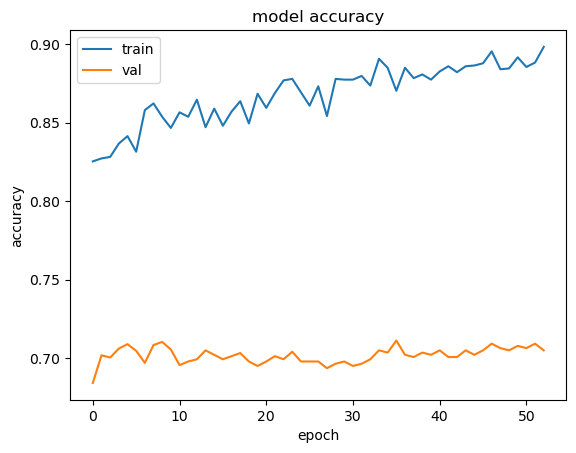

In [5]:

# retrain the best model
best_model = tuner.get_best_models(num_models=1)[0]

history = best_model.fit(
    x=[x_left_training, x_right_training],
    y=y_training,
    epochs=80,
    batch_size=32,
    validation_data=([x_left_val, x_right_val], y_val),
    callbacks=[early_stopping]
)

# plot training history
import matplotlib.pyplot as plt
plt.plot(history.history['ranking_accuracy'])
plt.plot(history.history['val_ranking_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')